In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, model_from_json
from keras.layers import GRU, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import FinanceDataReader as fdr

In [9]:
code = '005930'
date_start = '2016-09-02'
raw_df = fdr.DataReader(code, date_start)
#raw_df = pd.read_csv('Analysis/005930.KS.csv')
# raw_df.head()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1231 entries, 2016-09-02 to 2021-09-03
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1231 non-null   int64  
 1   High    1231 non-null   int64  
 2   Low     1231 non-null   int64  
 3   Close   1231 non-null   int64  
 4   Volume  1231 non-null   int64  
 5   Change  1231 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 67.3 KB


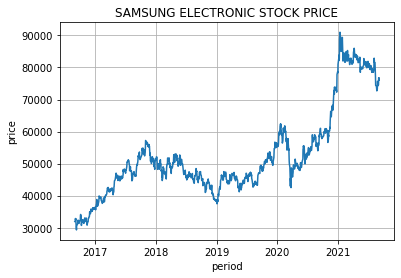

In [10]:
plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['Close'], label='Close')

plt.show()

In [11]:
# 통계정보 확인
raw_df.describe()

Open          High           Low         Close        Volume  \
count   1231.000000   1231.000000   1231.000000   1231.000000  1.231000e+03   
mean   52509.471162  53038.484159  51994.406174  52637.603574  1.103806e+07   
std    14031.393158  14144.793492  13912.395185  13756.057546  1.075807e+07   
min        0.000000      0.000000      0.000000  29300.000000  0.000000e+00   
25%    44500.000000  45000.000000  44125.000000  44665.000000  2.821795e+05   
50%    48900.000000  49300.000000  48300.000000  48880.000000  1.000978e+07   
75%    56380.000000  56960.000000  55810.000000  56400.000000  1.650665e+07   
max    90300.000000  96800.000000  89500.000000  91000.000000  9.030618e+07   

            Change  
count  1231.000000  
mean      0.000858  
std       0.016896  
min      -0.080357  
25%      -0.008642  
50%       0.000717  
75%       0.010239  
max       0.104706

In [12]:
# Missing Data 확인
raw_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

In [13]:
# 최소값이 0인 column 체크
for col in raw_df.columns:
    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Open <class 'str'>
High <class 'str'>
Low <class 'str'>
Volume <class 'str'>


In [15]:
# raw_df['Date'] = pd.to_datetime(raw_df['Date'])
# raw_df.set_axis(raw_df['Date'], inplace=True)
raw_df.drop(columns=['Open', 'High', 'Low', 'Change', 'Volume'], inplace=True)
raw_df.dropna(inplace=True)
raw_df

KeyError: "['Open' 'High' 'Low' 'Change' 'Volume'] not found in axis"

In [16]:
# 정규화 (Date 제외한 모든 수치부분 정규화)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
scaled_df = scaler.fit_transform(raw_df['Close'].values.reshape(-1,1))
# scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
print(scaled_df)

[[0.04278768]
 [0.04570502]
 [0.05769854]
 ...
 [0.76985413]
 [0.75688817]
 [0.76661264]]


In [51]:
# 학습데이터, 테스트데이터 생성
# close_data = raw_df['Close'].values
# close_data = close_data.reshape((-1,1))
close_data = scaled_df

split_percent = 0.90
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = raw_df.index[:split]
date_test = raw_df.index[split:]

print(len(close_train))
print(len(close_test))

1107
124


In [52]:
look_back = 20

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=10)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [54]:
# 모델 구축 및 컴파일
model = Sequential()
model.add(GRU(32, activation='relu', return_sequences=True, input_shape=(look_back,1)))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(1))
# sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 20, 32)            3360      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 22,241
Trainable params: 22,241
Non-trainable params: 0
_________________________________________________________________


In [55]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

num_epochs = 20
h5 = 'Analysis/GRU-{}-{}-trial-003.h5'.format(code, date_start)
checkpoint = ModelCheckpoint(h5,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10)

json = 'Analysis/GRU-{}-{}-trial-003.json'.format(code, date_start)
model_json = model.to_json()
with open(json, 'w') as json_file:
    json_file.write(model_json)

model.fit(train_generator, validation_data=test_generator, epochs=num_epochs,
          shuffle=False, callbacks=[checkpoint, early_stop])

Epoch 1/20
122/122 [==============================] - 3s 10ms/step - loss: 0.0047
Epoch 2/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0124
Epoch 3/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0100
Epoch 4/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0066
Epoch 5/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0046
Epoch 6/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0042
Epoch 7/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0033
Epoch 8/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 9/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0022
Epoch 10/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0020
Epoch 11/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0025
Epoch 12/20
122/122 [==============================] - 1s 10ms/step - loss: 0.0025
Epoch 13/20
1

In [59]:
def load_keras_model(json, h5, optimizer):
    json_file = open(json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss='mse')
    model.load_weights(h5)
    return model
model = load_keras_model('Analysis/GRU-005930-2016-09-02-trial-001.json',
                         'Analysis/GRU-005930-2016-09-02-trial-001.h5',
                         'adam')

In [24]:
# 모델 학습(EarlyStopping 적용)
# from keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', patience=5)

# model.fit(x_train, y_train,
#          validation_data=(x_test, y_test),
#          epochs=100, batch_size=16,
#          callbacks=[early_stop])

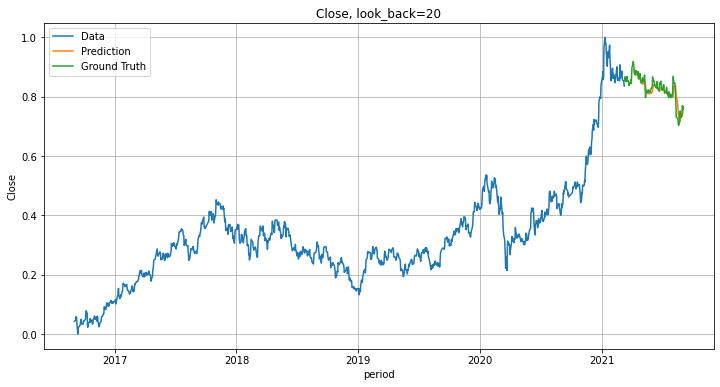

In [60]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

plt.figure(figsize=(12, 6))
plt.title('Close, look_back=20')
plt.ylabel('Close')
plt.xlabel('period')
plt.plot(date_train, close_train, label='Data')
plt.plot(date_test[look_back:], prediction, label='Prediction')
plt.plot(date_test, close_test, label='Ground Truth')
plt.grid()
plt.legend(loc='best')

plt.show()

In [46]:
# 평균절대값백분율오차계산 (MAPE)
print(np.sum(abs(close_test[look_back:]-prediction)/close_test[look_back:]) /len(close_test))

0.014419258075891409


In [61]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
    
    return prediction_list

def predict_dates(num_prediction):
    last_date = raw_df.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 20
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
valueee = scaler.inverse_transform(forecast.reshape(-1,1))
valueee[1]

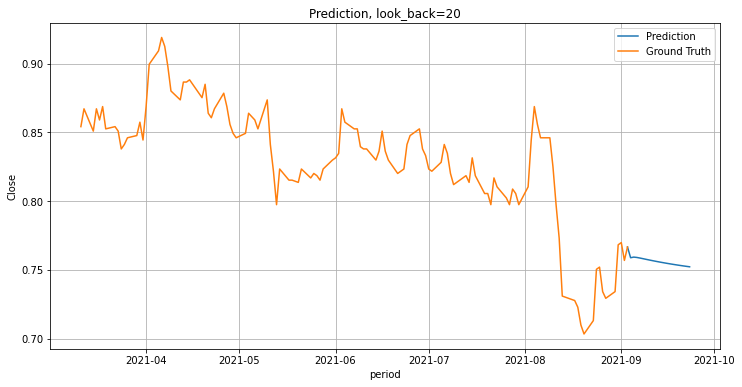

In [62]:
plt.figure(figsize=(12, 6))
plt.title('Prediction, look_back=20')
plt.ylabel('Close')
plt.xlabel('period')
# plt.plot(date_train, close_train, label='Data')
plt.plot(forecast_dates, forecast, label='Prediction')
plt.plot(date_test, close_test, label='Ground Truth')
plt.grid()
plt.legend(loc='best')

plt.show()